# Sentence compressor

### Project on natural language processing

##### Reading the dataset

In [1]:
import theano
import theano.tensor as T
import lasagne
import numpy as np

Using gpu device 0: GeForce GTX 960M (CNMeM is enabled with initial size: 75.0% of memory, cuDNN 5103)
/usr/local/lib/python2.7/dist-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
/usr/local/lib/python2.7/dist-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [2]:
import compression_data

In [3]:
data = compression_data.load_compression_data("compression-data.json.gz")

Function that convert array of tokkens to string, either compressed or not

In [4]:
def prase_array_to_string(prase, compressed = False):
    return ' '.join([t.form for t in filter(lambda t: t.label == 0 if compressed else True, prase)])
prase_array_to_string(data[2], True)

u'Luis Suarez was spotted in London'

#### Reading the word2vec embedings

In [5]:
import gensim
model = gensim.models.Word2Vec.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

Make embeding part of every token

In [6]:
from collections import namedtuple
from numpy.random import normal

np.random.seed(0)
unk = np.random.normal(scale = 0.1, size=300)
TokenWithEmb = namedtuple("TokenWithEmb", "form tag stem label emb")
data_with_emb = []

for phrase in data:
    new_phrase = []
    for word in phrase:
        new_phrase.append(TokenWithEmb(word.form, word.tag, word.stem, word.label, model[word.form]
                                  if word.form in model else unk))
    data_with_emb.append(new_phrase)
del model

#### Assign number to every tag

In [7]:
all_tags = [token.tag for phrase in data_with_emb for token in phrase]
tags_dict = {tag:i for i, tag in enumerate(set(all_tags))}

##### Split the dataset into train, test and dev sets

In [8]:
from sklearn.cross_validation import train_test_split
train_with_dev, test_set = data_with_emb[1000:], data_with_emb[:1000]
train_set, dev_set = train_test_split(train_with_dev, test_size = 1000, random_state = 0)

In [9]:
len(test_set), len(dev_set), len(train_set)

(1000, 1000, 8000)

#### Function to iterate over phrases

This function return one phrase at each yield, first field is matrix of embedings, second vector of tags encodings, third is vector of answers

In [10]:
def iterate (dataset, shuffle = True):
    perm = np.random.permutation(len(dataset)) if shuffle else range(len(dataset))
    for i in perm:
        yield (np.vstack(map(lambda token: token.emb, dataset[i])),
               np.array(map(lambda token: tags_dict[token.tag], dataset[i])),
               np.array(map(lambda token: token.label, dataset[i])))

#### Defining the network

In [11]:
X_emb = T.matrix('input','float32')
X_tag = T.ivector('tag')
Y = T.ivector('target')
embeding_size = 300
tag_emb_size = 200
rnn_size = 200
hid_size = 200
def network_architecture():
    #Input layer for word2vec embeding
    l_emb_in = lasagne.layers.InputLayer(shape=(None, embeding_size), input_var = X_emb)
    
    #Input layer for tag id
    l_tag_in = lasagne.layers.InputLayer(shape=(None, ),input_var = X_tag)
    
    #Embeding layer for tags
    l_emb = lasagne.layers.EmbeddingLayer(l_tag_in, input_size=len(tags_dict), output_size = tag_emb_size)
    
    #Concat word2vec embeding and tags embeding
    l_concat = lasagne.layers.ConcatLayer([l_emb_in, l_emb], axis = 1)
    
    #Reshape previous layer to fit RNN layer format 
    l_reshape = lasagne.layers.ReshapeLayer(l_concat, shape = (1, -1, embeding_size + tag_emb_size))
    
    #First recurent forward and backward layer and concatenation of them
    l_rnn_forward = lasagne.layers.LSTMLayer(l_reshape, grad_clipping = 100, num_units = rnn_size)
    l_rnn_backward = lasagne.layers.LSTMLayer(l_reshape, grad_clipping = 100, num_units = rnn_size, backwards=True)
    l_rnn = lasagne.layers.ConcatLayer([l_rnn_forward, l_rnn_backward], axis = 2)
    
    
    l_dropout = lasagne.layers.DropoutLayer(l_rnn)
    
    #Second recurent layer
    l_rnn_forward = lasagne.layers.LSTMLayer(l_dropout, grad_clipping = 100, num_units = rnn_size)
    l_rnn_backward = lasagne.layers.LSTMLayer(l_dropout, grad_clipping = 100, num_units = rnn_size, backwards=True)
    l_rnn = lasagne.layers.ConcatLayer([l_rnn_forward, l_rnn_backward], axis = 2)
    
    #Reshape to fit dence layer format
    l_shp = lasagne.layers.ReshapeLayer(l_rnn, shape = (-1, 2 * rnn_size))    
    
    #Dence layer with dropout
    l_hid = lasagne.layers.DenseLayer(l_shp, num_units = hid_size)    
    l_dropout = lasagne.layers.DropoutLayer(l_hid, p=0.25)
    
    #Dence layer with softmax nonlinerity, for final answer
    l_den = lasagne.layers.DenseLayer(l_dropout, num_units = 2, nonlinearity=lasagne.nonlinearities.identity)
    l_sden = lasagne.layers.ReshapeLayer(l_den, shape = (-1, 2))
    l_out = lasagne.layers.NonlinearityLayer(l_sden, nonlinearity=lasagne.nonlinearities.softmax)
    
    return l_out

network = network_architecture()

Defining the function for training and testing the network.  Network will be thrained using adam method.

In [12]:
def compile_network(l_out, learnig_rate):
    weights = lasagne.layers.get_all_params(l_out, trainable=True)
    network_output = lasagne.layers.get_output(l_out)
    network_output_det = lasagne.layers.get_output(l_out, deterministic = True)

    loss = lasagne.objectives.categorical_crossentropy(network_output, Y).mean()
    loss_det = lasagne.objectives.categorical_crossentropy(network_output_det, Y).mean()

    updates = lasagne.updates.adam(loss, weights, learning_rate = learnig_rate)


    #training functio
    train = theano.function([X_emb, X_tag, Y], loss, updates=updates, allow_input_downcast=True)

    #loss function
    compute_cost = theano.function([X_emb, X_tag, Y], loss_det, allow_input_downcast=True)

    #prediction function
    probs = theano.function([X_emb, X_tag], network_output_det, allow_input_downcast=True)
    
    return train, compute_cost, probs

train_func, compute_cost_func, probs_func = compile_network(network, 1e-3)

#### Training the network

Training cycle. Cycle consist of n_epoch. In each epoch network trained on every phrase in train set and score computed on dev set and train set 8 times per epoch. The network with highest dev score will be taken.

In [13]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
from IPython.display import clear_output
Losses = namedtuple("Losses", "acc f1 log match")


def compute_loss(dataset, threshold = 0.5):
    Y_true = []
    Y_predicted = []
    log_scores = []
    count_total_match = 0
    for X_emb, X_tag, Y in iterate(dataset, False):
        Y_true.append(Y)
        log_scores.append(compute_cost_func(X_emb, X_tag, Y))        
        p = (probs_func(X_emb, X_tag)[:,1] > threshold).astype(int)
        Y_predicted.append(p)
        count_total_match += np.array_equal(Y, p)
   
    Y_true = np.hstack(Y_true)
    Y_predicted = np.hstack(Y_predicted)
    
    return Losses(acc = accuracy_score(Y_true, Y_predicted),
                  f1 = f1_score(1-Y_true, 1-Y_predicted),
                  log = np.mean(log_scores),
                  match = count_total_match / float(len(dataset)))

def trainig_cycle(n_epochs, batch_per_loss):
    print("Training ...")
    np.random.seed(0)
    
    best_score = 10000000
    best_weight = None
    
    train_losses = []
    dev_losses = []    
    for epoch in range(n_epochs):     
        
        for i, (X_emb, X_tag, Y) in enumerate(iterate(train_set)):
            tr_loss = train_func(X_emb, X_tag,  Y)
            batches = (epoch * len(train_set)  + i + 1)
            
            #compute score several times per epoch, in order for plots to be smoth
            if batches % batch_per_loss == 0:
                
                train_loss = compute_loss(train_set)
                train_losses.append(train_loss)
                dev_loss = compute_loss(dev_set)
                dev_losses.append(dev_loss)
                
                if dev_loss.log < best_score:
                    best_weight = lasagne.layers.get_all_param_values(network)
                    best_score = dev_loss.log

                print "Batches %d:" % batches
                print "train loss - %s" % (train_loss,)
                print "dev loss - %s" % (dev_loss,)
                clear_output(True)
                
    return train_losses, dev_losses, best_weight

batches_per_epoch = 1000
train_loss, dev_loss, best_weight = trainig_cycle(4, batches_per_epoch)
lasagne.layers.set_all_param_values(network, best_weight)

Batches 32000:
train loss - Losses(acc=0.90290274946221727, f1=0.87538444387611225, log=0.23079734, match=0.333625)
dev loss - Losses(acc=0.8367572692793932, f1=0.77913192217233274, log=0.40085876, match=0.184)


#### Pressision recall curve

Populating the interactive namespace from numpy and matplotlib
Best threshold 0.513372


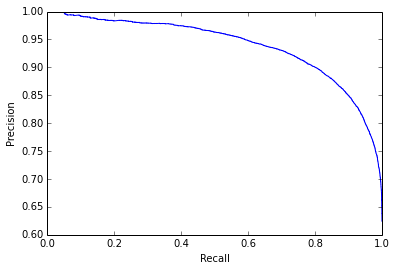

In [14]:
%pylab inline
from sklearn.metrics import precision_recall_curve

Y_predicted = []
Y_true = []
for i, (X_emb, X_tag, Y) in enumerate(iterate(dev_set, False)):
    predictions = probs_func(X_emb, X_tag)[:, 1]
    Y_predicted += list(predictions)
    Y_true += list(Y)

precision, recall, thresholds = precision_recall_curve(Y_true, Y_predicted)

max_f1, best_threshold = max(map(lambda t: ( 2 * (t[0] * t[1]) / (t[0] + t[1]) ,t[2]), zip(precision, recall, thresholds)))

print ("Best threshold %f" % best_threshold)

plt.plot(recall, precision, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig("report/precision_recal_curve.pdf")
plt.show()

#### Learing curves

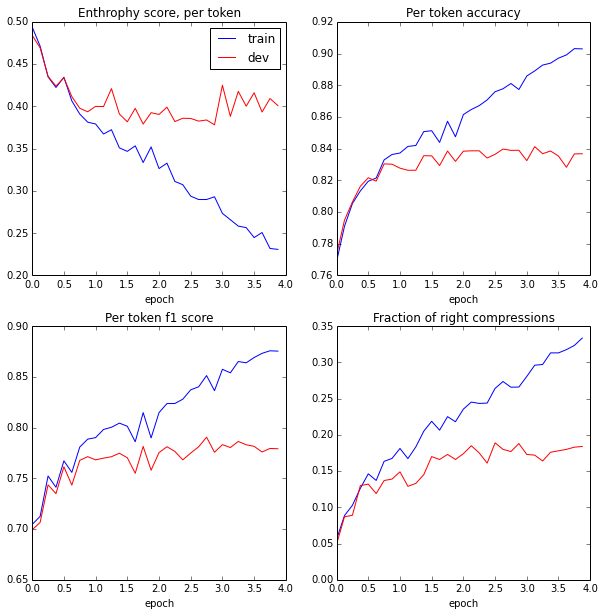

In [15]:
plt.figure(figsize=(10,10))
batches_per_epoch = 1000

x_axis = np.array(range(len(train_loss))).astype(float) / (len(train_set) / batches_per_epoch)
plt.subplot(221)
plt.plot(x_axis, map(lambda x: x.log, train_loss), c='b', label = 'train')
plt.plot(x_axis, map(lambda x: x.log, dev_loss), c='r', label = 'dev')
plt.title('Enthrophy score, per token')
plt.xlabel("epoch")
plt.legend()

plt.subplot(222)
plt.plot(x_axis, map(lambda x: x.acc, train_loss), c='b', label = 'train')
plt.plot(x_axis, map(lambda x: x.acc, dev_loss), c='r', label = 'dev')
plt.title('Per token accuracy')
plt.xlabel("epoch")


plt.subplot(223)
plt.plot(x_axis, map(lambda x: x.f1, train_loss), c='b', label = 'train')
plt.plot(x_axis, map(lambda x: x.f1, dev_loss), c='r', label = 'dev')
plt.title('Per token f1 score')

plt.xlabel("epoch")

plt.subplot(224)
plt.plot(x_axis, map(lambda x: x.match, train_loss), c='b', label = 'train')
plt.plot(x_axis, map(lambda x: x.match, dev_loss), c='r', label = 'dev')
plt.title('Fraction of right compressions')
plt.xlabel("epoch")

plt.savefig("report/learning_curves.pdf")
plt.show()

#### Evaluation

Compute the accuracy and auc in every phrase and report the avearag. Also compute the number of phrases that match exactly.

In [16]:
test_loss = compute_loss(test_set, 1 - best_threshold)
print "Per token accuracy: %f" % test_loss.acc
print "Per token f1 score: %f" % test_loss.f1
print "Fraction of right compressions %f" % test_loss.match

Per token accuracy: 0.828691
Per token f1 score: 0.764308
Fraction of right compressions 0.159000


#### Print top10 best and top10 worst phrases

In [17]:
from itertools import compress
def compress_phrase_from_test(number):
    for X_emb, X_tag, Y in iterate(test_set[number:(number+1)], False):
        probs = probs_func(X_emb, X_tag)
        predictions = (probs[:,1] > best_threshold).astype(int)
        phrase = prase_array_to_string(test_set[number])
        phrase_compressed = prase_array_to_string(test_set[number], True)
        phrase_compression_prediction = ' '.join(map(lambda x: x.form, compress(test_set[number], 1 - predictions)))
        return [phrase, phrase_compressed, phrase_compression_prediction]


In [18]:
scores = []
for i, (X_emb, X_tag, Y) in enumerate(iterate(test_set, False)):
    predictions = (probs_func(X_emb, X_tag)[:, 1] > 0.5).astype(int)
    scores.append((accuracy_score(Y, predictions), i))
scores.sort()   

** Worst compressions **

In [19]:
bad = []
for score, i in scores[:5]:
    item = compress_phrase_from_test(i)
    bad.append(item)
    print "Phrase:\t'%s'" % item[0]
    print "True compression:\t'%s'" % item[1]
    print "Compression prediction:\t'%s'" % item[2]

Phrase:	'However that means high quality players are being left on the bench so which of this Newcastle quintet should feel most hard done by'
True compression:	'that means so which of this Newcastle quintet should feel most hard done by'
Compression prediction:	'that means high quality players are being left on the bench'
Phrase:	'The second wild is the picture of all five of the Girls people roulette online chat Guns'
True compression:	'people roulette online chat Guns'
Compression prediction:	'The second wild is the picture of all five of the roulette Guns'
Phrase:	'Stocks to watch on the Australian stock exchange at the close on Tuesday'
True compression:	'Stocks to watch at the close on Tuesday'
Compression prediction:	'Stocks to watch on the Australian stock exchange'
Phrase:	'Stocks to watch on the Australian stock exchange at the close on Wednesday'
True compression:	'Stocks to watch at the close on Wednesday'
Compression prediction:	'Stocks to watch on the Australian stock exc

** Best compressions **

In [20]:
good = []
for score, i in scores[-5:]:
    item = compress_phrase_from_test(i)
    good.append(item)
    print "Phrase:\t'%s'" % item[0]
    print "True compression:\t'%s'" % item[1]
    print "Compression prediction:\t'%s'" % item[2]

Phrase:	'Actress NAOMI WATTS walked out of a radio interview as she was promoting her new movie DIANA'
True compression:	'NAOMI WATTS walked out of a radio interview'
Compression prediction:	'NAOMI WATTS walked out of a radio interview'
Phrase:	'Nice Ride bikes will make their spring debut on city streets Saturday and riders can now keep them for twice as long'
True compression:	'Nice Ride bikes will make their spring debut'
Compression prediction:	'Nice Ride bikes will make their spring debut'
Phrase:	'Applications for jobless benefits dropped 24,000 last week to a seasonally adjusted 334,000 another positive sign of the job market 's steady recovery'
True compression:	'Applications for jobless benefits dropped 24,000'
Compression prediction:	'Applications for jobless benefits dropped 24,000'
Phrase:	'Not following its key ally Saudi Arabia 's on Syria Pakistan Thursday asserted that Syrian people should decide their future set up'
True compression:	'Syrian people should decide their 

In [21]:
import pandas as pd
pd.DataFrame(bad, columns=["Phrase", "True", "Predicted"]).to_csv("report/bad_compressions.csv", index=False, encoding='utf-8')
pd.DataFrame(good, columns=["Phrase", "True", "Predicted"]).to_csv("report/good_compressions.csv", index=False, encoding='utf-8')